In [1]:
# define a few usefull functions to use in the future
# the problem with the vscode inline image presenting that
# could not show the images specially fft applied image would be
# gone using this functions, hopefully. :)

from skimage import io, morphology
import cv2
import numpy as np
from scipy import signal
from scipy import ndimage
import matplotlib.pylab as plt
from skimage.measure import regionprops
from matplotlib.image import imread
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# this will be used to show a signle image
def showImage(image, title="", minmax=None, figuersize=(8, 8), gray=True):
    plt.figure(figsize=figuersize)
    plt.title(title)
    if gray:
        if minmax:
            plt.imshow(image, cmap='gray', vmin=minmax[0], vmax=minmax[1])
        else:
            plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# this one will be used to show multiple image
# argument should be pass in a zipped format like this:
# [1_image, 2_image, ...], [1_text, 2_text, ...]
def showAll(imageList, titleList, minmaxList=None):
    imageListLen = len(imageList)
    numRows = int(np.ceil(imageListLen/2))
    fig = plt.figure(figsize=(7 * 3, 6*numRows))
    for i in range(imageListLen):
        ax = fig.add_subplot(numRows, 4, i + 1)
        try:
            ax.set_title(titleList[i])
        except:
            pass
        if minmaxList:
            ax.imshow(imageList[i], cmap='gray',
                      vmin=minmaxList[i][0], vmax=minmaxList[i][1])
        else:
            ax.imshow(imageList[i], cmap='gray')
    plt.show()


C:\Users\Hessam\AppData\Local\Temp\ipykernel_7948\1982220974.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


Question 1

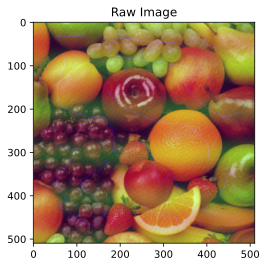

In [2]:
# reading and showing image
rgb_f = io.imread('f.png', as_gray=False)
showImage(rgb_f, "Raw Image", figuersize=(4, 4))


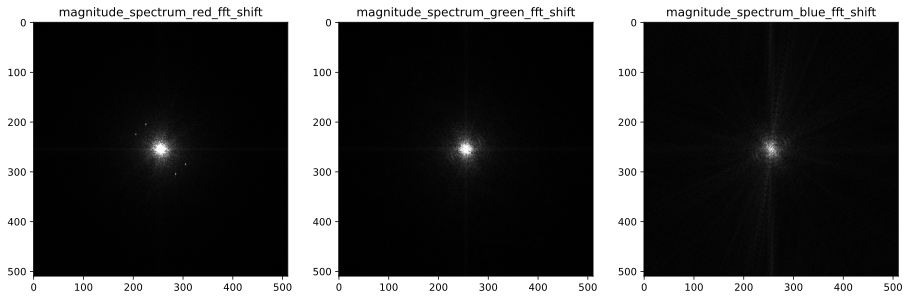

In [33]:
# seperating red and green and blue channels
red = rgb_f[:, :, 0]
green = rgb_f[:, :, 1]
blue = rgb_f[:, :, 2]

# applying fft and shift origin to red
red_fft = np.fft.fft2(red)
red_fft_shift = np.fft.fftshift(red_fft)
magnitude_spectrum_red_fft_shift = np.abs(red_fft_shift)/(510*511)

# applying fft and shift origin to green
green_fft = np.fft.fft2(green)
green_fft_shift = np.fft.fftshift(green_fft)
magnitude_spectrum_green_fft_shift = np.abs(green_fft_shift)/(510*511)

# applying fft and shift origin to green
blue_fft = np.fft.fft2(blue)
blue_fft_shift = np.fft.fftshift(blue_fft)
magnitude_spectrum_blue_fft_shift = np.abs(blue_fft_shift)/(510*511)

# showing them all
showAll(
    [
        magnitude_spectrum_red_fft_shift,
        magnitude_spectrum_green_fft_shift,
        magnitude_spectrum_blue_fft_shift
    ],
    [
        "magnitude_spectrum_red_fft_shift",
        "magnitude_spectrum_green_fft_shift",
        "magnitude_spectrum_blue_fft_shift"
    ],
    [
        (0, 1),
        (0, 1),
        (0, 1)
    ]
)


In [6]:
# Butterworth is a lowpass filter, so we use that to filter the image
def butterworth(n, d0, img):
    h = np.empty([img.shape[0], img.shape[1]])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            h[i, j] = 1 / (1 + (((i - img.shape[0]/2)**2 +
                                 (j - img.shape[1]/2)**2)**0.5 / d0)**(2*n))
    return h


def noch(n, cutf1, cutf2, img):
    h1 = butterworth(n, cutf1, img)
    h2 = butterworth(n, cutf2, img)
    _h = 1 - (h2 - h1)
    return _h


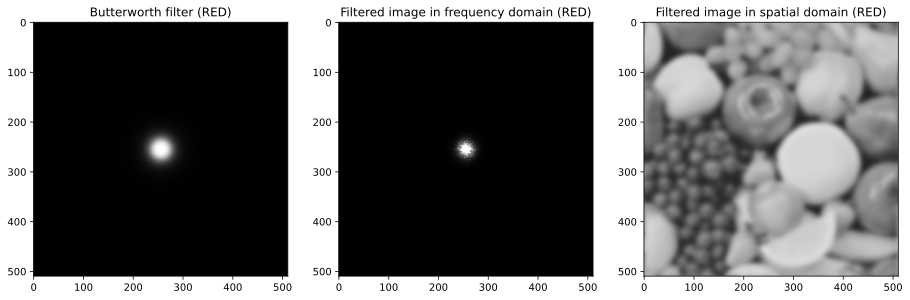

In [7]:
h_red = butterworth(2, 22, red)
red_fft_shift_filter = red_fft_shift * h_red
red_fft_Ishift_filter = np.fft.ifftshift(red_fft_shift_filter)
red_Ifft_Ishift_filter = np.absolute(np.fft.ifft2(red_fft_Ishift_filter))

showAll(
    [
        h_red,
        np.abs(red_fft_shift_filter)/(510*511),
        red_Ifft_Ishift_filter
    ],
    [
        "Butterworth filter (RED)",
        "Filtered image in frequency domain (RED)",
        "Filtered image in spatial domain (RED)"
    ],
    [
        (0, 1),
        (0, 1),
        (0, 255)
    ]
)


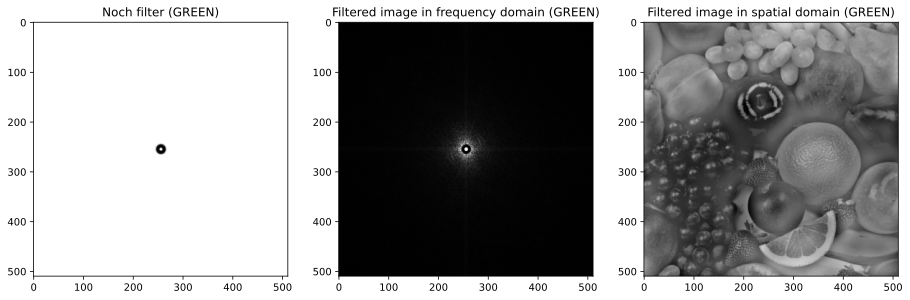

In [8]:
h_green = noch(10, 3, 10, green)
green_fft_shift_filter = green_fft_shift * h_green
green_fft_Ishift_filter = np.fft.ifftshift(green_fft_shift_filter)
green_Ifft_Ishift_filter = np.absolute(np.fft.ifft2(green_fft_Ishift_filter))
showAll(
    [
        h_green,
        np.abs(green_fft_shift_filter)/(510*511),
        green_Ifft_Ishift_filter
    ],
    [
        "Noch filter (GREEN)",
        "Filtered image in frequency domain (GREEN)",
        "Filtered image in spatial domain (GREEN)"
    ],
    [
        (0, 1),
        (0, 1),
        (0, 255)
    ]
)


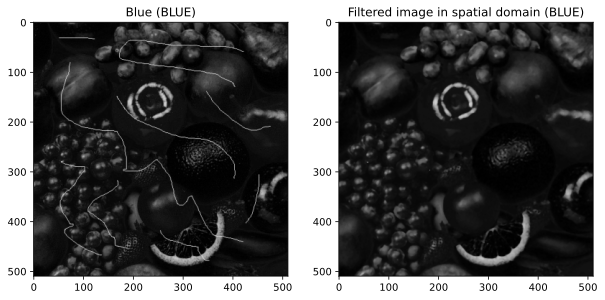

In [9]:
# for the blue lines, the best filter is median because they are so thin
blue_filter = ndimage.median_filter(blue, size=4)

showAll(
    [
        blue,
        blue_filter
    ],
    [
        "Blue (BLUE)",
        "Filtered image in spatial domain (BLUE)"
    ]
)


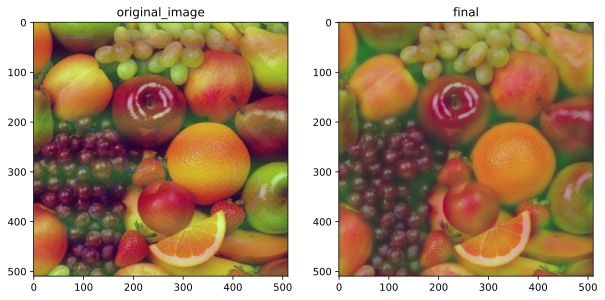

In [15]:
# finally we get all the channels together again to have the RGB photo
final = (np.dstack((red_Ifft_Ishift_filter,
                    green_Ifft_Ishift_filter, blue_filter))).astype(np.uint8)

showAll([rgb_f, final], ["original_image", 'final'])


Question 2

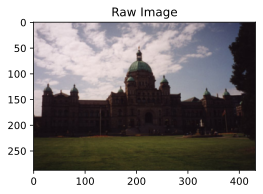

In [16]:
# reading and showing the image
be = io.imread('badexposure.jpg', as_gray=False)
showImage(be, "Raw Image", figuersize=(4, 4))


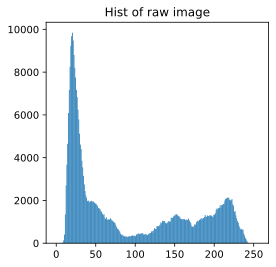

In [17]:
# plotting histogram
plt.figure(figsize=(4, 4))
plt.title("Hist of raw image")
plt.hist(be.ravel(), 256, [0, 256])
plt.show()


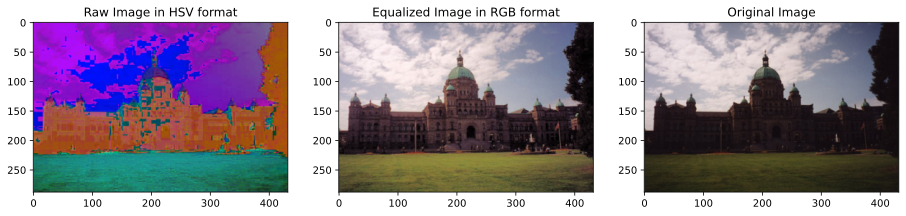

In [20]:
# creating HSV and hist-equalization
be_hsv = cv2.cvtColor(be, cv2.COLOR_RGB2HSV)
v3 = be_hsv[:, :, 2]
v3_eq = cv2.equalizeHist(v3)
be_hsv[:, :, 2] = v3_eq
be_eq = cv2.cvtColor(be_hsv, cv2.COLOR_HSV2RGB)
showAll(
    [
        be_hsv,
        be_eq,
        be
    ],
    [
        "Raw Image in HSV format",
        "Equalized Image in RGB format",
        'Original Image'
    ]
)


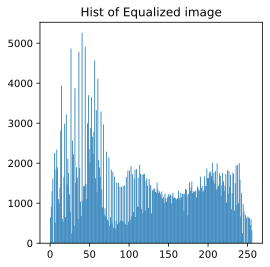

In [34]:
# plotting the final histogram
plt.figure(figsize=(4, 4))
plt.title("Hist of Equalized image")
plt.hist(be_eq.ravel(), 256, [0, 256])
plt.show()


Question 3


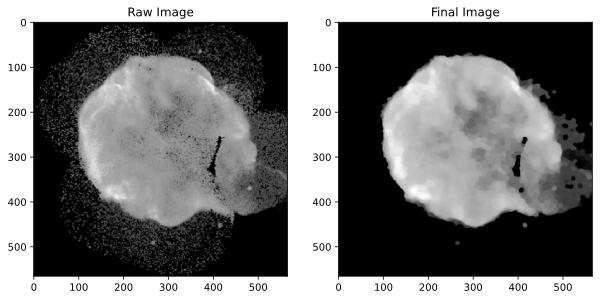

In [35]:
# reading image
Q4_1 = io.imread('Q4_1.tif', as_gray=True)

# applying morphological filters
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
opening = cv2.morphologyEx(Q4_1, cv2.MORPH_OPEN, se)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, se)

showAll(
    [
        Q4_1,
        closing
    ],
    [
        "Raw Image",
        "Final Image"
    ]
)

# such a beautiful result :))

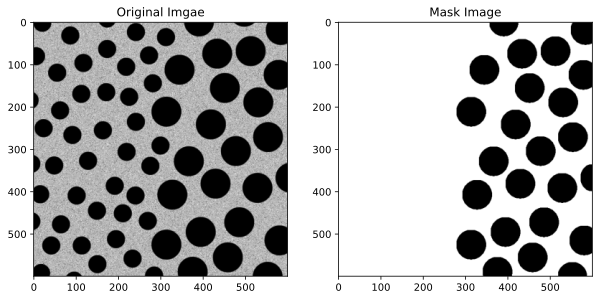

In [26]:
# reading image
Q4_4 = io.imread('Q4_4.tif', as_gray=True)

# applying morphological filtering
Q4_4 = Q4_4/255
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))
big = cv2.morphologyEx(Q4_4, cv2.MORPH_CLOSE, se)
mask = cv2.threshold(big, 0.5, 1, cv2.THRESH_BINARY)

showAll(
    [
        Q4_4,
        mask[1]
    ],
    [
        'Original Imgae',
        "Final Image"
    ]
)


C:\Users\Hessam\AppData\Local\Temp\ipykernel_7948\648952277.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ((np.logical_not(bin_Q4_4[1])) * mask[1])).astype(np.float)


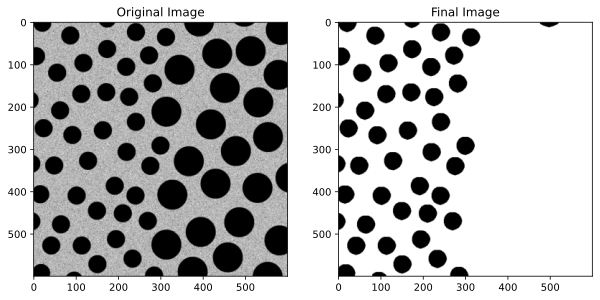

In [28]:
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
bin_Q4_4 = cv2.threshold(Q4_4, 0.5, 1, cv2.THRESH_BINARY)
small_not = np.logical_not(
    ((np.logical_not(bin_Q4_4[1])) * mask[1])).astype(np.float)
small = cv2.morphologyEx(small_not, cv2.MORPH_CLOSE, se)
bin_small = cv2.threshold(small, 0.5, 1, cv2.THRESH_BINARY)

showAll(
    [
        Q4_4,
        bin_small[1]
    ],
    [
        'Original Image',
        "Final Image"
    ]
)


Question 4

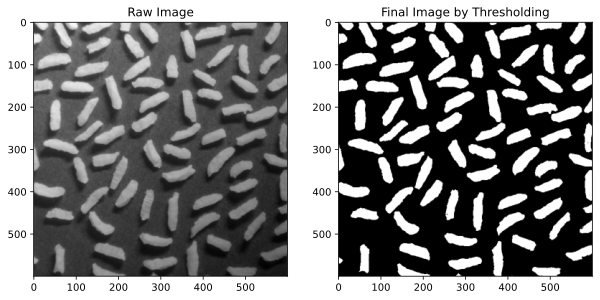

In [29]:
# reading image
Q4_3 = io.imread('Q4_3.tif', as_gray=True)
Q4_3 = Q4_3/255

# applying morphological transformation
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 100))
Q4_3_tophat = cv2.morphologyEx(Q4_3, cv2.MORPH_TOPHAT, se)
bin_Q4_3 = cv2.threshold(Q4_3_tophat, 0.24, 1, cv2.THRESH_BINARY)

showAll(
    [
        Q4_3,
        bin_Q4_3[1]
    ],
    [
        "Raw Image",
        "Final Image by Thresholding"
    ]
)


In [30]:
# couting the rices
bw_Q = bin_Q4_3[1]
bw_Q = bw_Q * 255
rice = bw_Q.astype(np.uint8)
n_rice, mat = cv2.connectedComponents(rice)
print(f"Number of rice peaces: {n_rice}")

Number of rice peaces: 82


In [32]:
# calculating the mean of the rice area
region = regionprops(mat)
i = 0
s = 0
for p in region:
    i += 1
    s += p['Area']
print(f"Mean of the rice area is : {s / i}")

Mean of the rice erea is : 1251.8271604938273
